## Import modules

In [1]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more

from brain_tumor_dataset import BrainTumorDataset     # Dataset
import classification_models as models                # Module for models
from trainer import Trainer, ModelCheckpoint          # Trainer Class

/home/poggers/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing Dataset | (from .mat to .npy)

Download and unzip dataset

In [ ]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

Convert .mat to .npy

In [ ]:
data = {'image':[], 'label':[]}
index = 0
for i in range(3064):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    img = np.array(f.get('cjdata/image'), dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data['image'].append(name)
      data['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1

Save labels in a CSV file

In [ ]:
df = pd.DataFrame(data)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data

Remove MAT files

In [ ]:
!rm -rf tmp_dataset

## Functions Tools

In [2]:
def split_dataset(dataset, train_size=0.8):
  n = len(dataset)
  n_train = int(n*train_size)
  n_val = n - n_train
  train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])
  return train_dataset, val_dataset

def plot_train_loss(model_dic, label=None, legend='upper center', model_name=None):
  """
     This method allows you to view the history of the loss function per epoch
  """
  train_loss_history = model_dic['train_loss_history']
  x_values = range(1, len(train_loss_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Training loss')
  else:
    plt.title('Training loss using ' + model_name)

  if label is not None:
    plt.plot(x_values, train_loss_history, '-o', label=label)
    plt.legend(loc=legend)
  else:
    plt.plot(x_values, train_loss_history, '-o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def plot_accuracy(model_dic, model_name=None):
  """
     This method allows you to view the historical accuracy per epoch
  """  
  train_acc_history = model_dic['train_acc_history']
  val_acc_history = model_dic['val_acc_history']
  x_values = range(1, len(train_acc_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Accuracy')
  else:
    plt.title('Accuracy using ' + model_name )
  plt.plot(x_values, train_acc_history, '-o', label='train')
  plt.plot(x_values, val_acc_history, '-o', label='val')
  plt.ylabel('Accuracy')  
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.show()

## Config GPU and Seed

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cpu


In [4]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

## Load Dataset and Create DataLoaders

In [5]:
# Load Dataset
dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [6]:
# Split train_data for training and validation
train_set, val_set = split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [7]:
# Create Loaders
train_dataloader = data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = data.DataLoader(test_data, batch_size=32, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dataloader))
print('Validation data: ', len(val_dataloader))
print('Test data: ', len(test_dataloader))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  20


## View Dataset

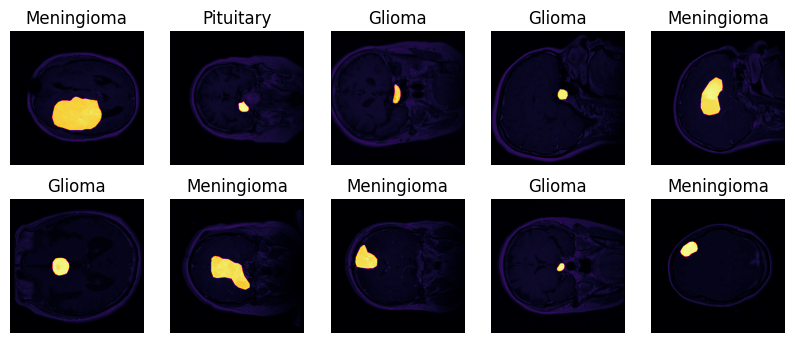

In [8]:
labels = ['Meningioma', 'Glioma', 'Pituitary']
plt.figure(figsize=(10, 4))
for i in range(10):
  index = random.randint(0, len(train_data)-1)
  image, label = train_data[index]
  image = (image*0.5 + 0.5).numpy()
  
  mask = 0.25*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(labels[label.item()-1]))
  plt.imshow(mask, cmap='inferno')

In [ ]:
model = models.ClasificatorSimpleModel()

# TODO: Create SGD optimizer with learning rate equal to 0.01
optimizer = optim.Adam(model.parameters(), 0.01)

# TODO: Train the model using 10 epochs
epochs = 10
conv_simple_network_dic = Trainer.train(
  train_dataloader,
  val_dataloader,
  model,
  optimizer,
  device,
  epochs,
  ModelCheckpoint(verbose=True)
)

In [9]:
model = models.ClasificatorCustomModel()

# TODO: Create SGD optimizer with learning rate equal to 0.01
optimizer = optim.Adam(model.parameters(), 0.01)

# TODO: Train the model using 10 epochs
epochs = 10
conv_network_dic = Trainer.train(
  train_dataloader,
  val_dataloader,
  model,
  optimizer,
  device,
  epochs,
  ModelCheckpoint(verbose=True)
)

Train Phase:  14%|███████                                            | 8/58 [00:26<02:44,  3.29s/it]


KeyboardInterrupt: 

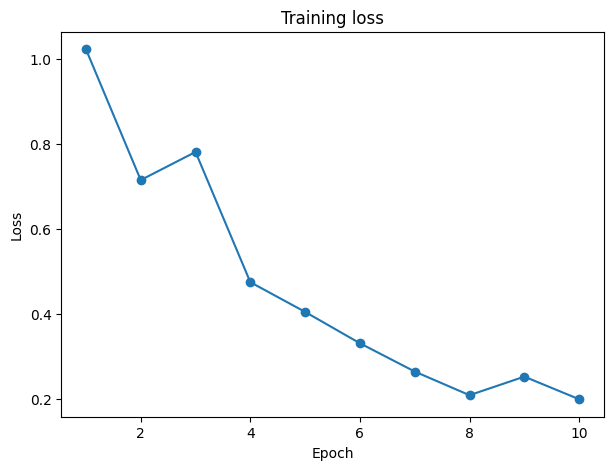

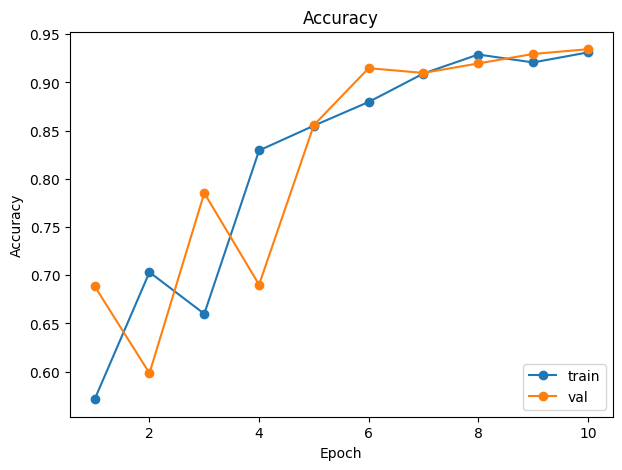

In [10]:
plot_train_loss(conv_network_dic)
plot_accuracy(conv_network_dic)